In [1]:
dataset_path = '/kaggle/input/eurosat-rgb/EuroSAT_RGB'


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
print(tf.__version__)


2.17.0


In [3]:
train_dir = dataset_path
test_dir = dataset_path

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [5]:
train_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


Found 21600 images belonging to 10 classes.


In [6]:
test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 5400 images belonging to 10 classes.


In [7]:
train_data.num_classes, train_data.class_indices

(10,
 {'AnnualCrop': 0,
  'Forest': 1,
  'HerbaceousVegetation': 2,
  'Highway': 3,
  'Industrial': 4,
  'Pasture': 5,
  'PermanentCrop': 6,
  'Residential': 7,
  'River': 8,
  'SeaLake': 9})

In [8]:
class_names = list(train_data.class_indices.keys())
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Data Visualization


In [9]:
import numpy as np
import matplotlib.pyplot as plt

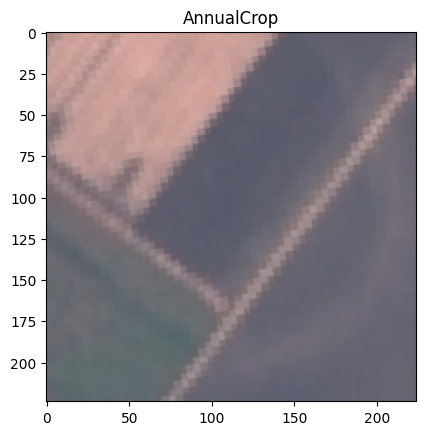

In [10]:
for images, labels in train_data:
    plt.imshow(images[0])
    plt.title(class_names[np.argmax(labels[0])])
    break

## Model

In [11]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

#model.summary()

In [14]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

In [16]:
model.fit(train_data, epochs=10, validation_data=test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 320s 448ms/step - categorical_accuracy: 0.4750 - loss: 1.4979 - val_categorical_accuracy: 0.7080 - val_loss: 0.9073
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 252s 369ms/step - categorical_accuracy: 0.7065 - loss: 0.8576 - val_categorical_accuracy: 0.7191 - val_loss: 0.7836
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 251s 368ms/step - categorical_accuracy: 0.7469 - loss: 0.7349 - val_categorical_accuracy: 0.7654 - val_loss: 0.6478
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 248s 363ms/step - categorical_accuracy: 0.7730 - loss: 0.6658 - val_categorical_accuracy: 0.7600 - val_loss: 0.6794
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 249s 366ms/step - categorical_accuracy: 0.7842 - loss: 0.6158 - val_categorical_accuracy: 0.7841 - val_loss: 0.6247
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 251s 369ms/step - categorical_accuracy: 0.7887 - loss: 0.5960 - val_categorical_accuracy: 0.7922 - val_loss: 0.5809
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 248s 364ms/step - categorical_accur

## Fine Tuning

In [19]:
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(
    train_data,
    epochs=15,
    initial_epoch=10,
    validation_data=test
)

Epoch 11/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 437s 575ms/step - accuracy: 0.3544 - loss: 1.9242 - val_accuracy: 0.8517 - val_loss: 0.4425
Epoch 12/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 389s 572ms/step - accuracy: 0.8739 - loss: 0.3725 - val_accuracy: 0.9331 - val_loss: 0.1941
Epoch 13/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 389s 572ms/step - accuracy: 0.9255 - loss: 0.2193 - val_accuracy: 0.9022 - val_loss: 0.3193
Epoch 14/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 386s 569ms/step - accuracy: 0.9317 - loss: 0.2016 - val_accuracy: 0.9413 - val_loss: 0.1948
Epoch 15/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 387s 569ms/step - accuracy: 0.9455 - loss: 0.1579 - val_accuracy: 0.9498 - val_loss: 0.1412


In [25]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.9500 - loss: 0.1408
Test Accuracy: 94.98%
